# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2021

## Project 3 - Triangular mesh generator

Due Friday, April 2

First we include some libraries and define utility functions from the lecture notes:

In [18]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](first.(p), last.(p))
    t = Int64.(t[:triangles] .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

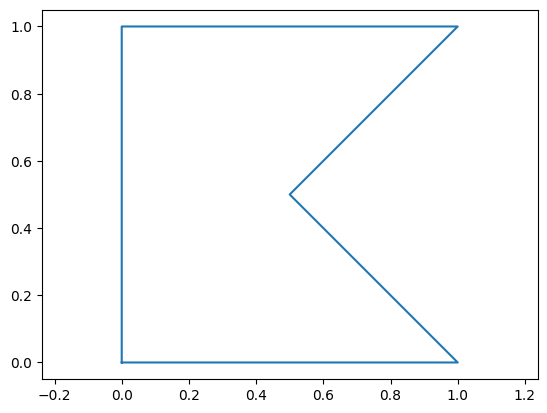

In [19]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <http://geomalgorithms.com/a03-_inclusion.html>.

In [20]:
 #= 
    pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
    p = [-0.2,0.0]

    C = []
    for i = 1:length(EN)
        if EN[i][2,1] > EN[i][2,2]
            push!(C,-1)
        else
            push!(C,+1)
        end
    end
    println(C)
=#

In [21]:
using PyPlot, LinearAlgebra

function inpolygon(p,pv)

    smax = findmax(collect(pv[i][1] for i = 1:length(pv)))[1] #finding largest xvalue in pv

    p_ray = [p[1] smax+1;p[2] p[2]] #creating a straight array extending beyond the max x value in pv
    
    E = [] #formation of 2x2 matrix representing edges of pv
    for i = 1:(length(pv)-1)
         push!(E, [pv[i] pv[i+1]])
    end
    
    EN = [] #to determine if edge is increasing or decreasing
    for i = 1:length(E)
        if findmin([E[i][1,1],E[i][1,2]])[2] == 2.0
            push!(EN,[E[i][:,2] E[i][:,1]])
        else
            push!(EN, E[i])
        end
    end

    function linesegment_intersect(p1, p2, q1, q2)
        A = [p2-p1 q1-q2]
        b = q1-p1
        if rank(A) == 2
            st = A \ b
            if all(0 .≤ st .≤ 1)
                pintersect = p1 + st[1] * (p2 - p1)
                if ((q2[2] < q1[2]) && (pintersect[2] == q1[2])) || ((q1[2] > q2[2]) && (pintersect[2] == q2[2]))
                    return false
                else
                    return true
                end
            else
                return false
            end
        else
            return false
        end
    end

    p1 = p_ray[:,1]
    p2 = p_ray[:,2]

    cn = 0
    for i = 1:length(EN)
        q1 = EN[i][:,1]
        q2 = EN[i][:,2]
        if linesegment_intersect(p1, p2, q1, q2) == true
            cn +=1
        end
    end
    

    if (cn % 2 == 0)
        return false
    else
        return true
    end
end

inpolygon (generic function with 1 method)

### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [22]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Array{Array{Float64,1},1}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

In [23]:
side1 = sqrt(sum((tri[2]-tri[1]).^2))
side2 = sqrt(sum((tri[3]-tri[2]).^2))
side3 = sqrt(sum((tri[1]-tri[3]).^2))
side1, side2, side3

(1.118033988749895, 2.8284271247461903, 2.692582403567252)

In [24]:
s = (side1 + side2 + side3)/2

3.3195217585316685

In [25]:
Area = sqrt(s*((s-side1)*(s-side2)*(s-side3)))

1.5

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [26]:
function tri_area(tri)
    #find length of sides connecting the points
    side1 = sqrt(sum((tri[2]-tri[1]).^2))
    side2 = sqrt(sum((tri[3]-tri[2]).^2))
    side3 = sqrt(sum((tri[1]-tri[3]).^2))
    #use Heron's formula
    s = (side1 + side2 + side3)/2
    Area = sqrt(s*((s-side1)*(s-side2)*(s-side3)))
    return Area
end

tri_area (generic function with 1 method)

In [27]:
tri_area(tri)

1.5

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [28]:
function tri_centroid(tri)
    #area of tri = 1/3(area of two points on tri and centroid)
    #A = sqrt(sum((tri[2]-tri[1]).^2))
    #B = sqrt(sum((tri[3]-tri[2]).^2))
    #C = sqrt(sum((tri[1]-tri[3]).^2))
    #G = ((A*(B^2))+(B*(C^2))+((C*A^2)))/3((A^2)+(B^2)+(C^2))
    
    x = (tri[1][1]+tri[2][1]+tri[3][1])/3
    y = (tri[1][2]+tri[2][2]+tri[3][2])/3
    return x,y
    
end

tri_centroid (generic function with 1 method)

In [29]:
tri_centroid(tri)

(1.0, 1.5)

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [30]:
function tri_circumcenter(tri)
    A = tri[1]
    B = tri[2]
    C = tri[3]
    Ax = A[1]
    Ay = A[2]
    Bx = B[1]
    By = B[2]
    Cx = C[1]
    Cy = C[2]
    D = 2((Ax*(By-Cy))+(Bx*(Cy-Ay))+(Cx*(Ay-By)))
    Ux = (1/D)*((((Ax^2)+(Ay^2))*(By-Cy))+(((Bx^2)+(By^2))*(Cy-Ay))+(((Cx^2)+(Cy^2))*(Ay-By)))
    Uy = (1/D)*((((Ax^2)+(Ay^2))*(Cx-Bx))+(((Bx^2)+(By^2))*(Ax-Cx))+(((Cx^2)+(Cy^2))*(Bx-Ax)))
    
    Bp = B .- A
    Cp = C .- A
    Bpx = Bp[1]
    Bpy = Bp[2]
    Cpx = Cp[1]
    Cpy = Cp[2]
    Dp = 2*((Bpx*Cpy)-(Bpy*Cpx))
    
    Uxp = (1/Dp)*(Cpy*((Bpx^2)+(Bpy^2))-(Bpy*((Cpx^2)+Cpy^2)))
    Uyp = (1/Dp)*(Bpx*((Cpx^2)+(Cpy^2))-(Cpx*((Bpx^2)+Bpy^2)))
    
    Up = [Uxp, Uyp]
    U = Up + A
    return U
end

tri_circumcenter (generic function with 1 method)

In [31]:
tri_circumcenter(tri)

2-element Array{Float64,1}:
 0.9166666666666666
 1.9166666666666665

### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A>h_\mathrm{max}^2/2$, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A>h_\mathrm{max}^2/2$.

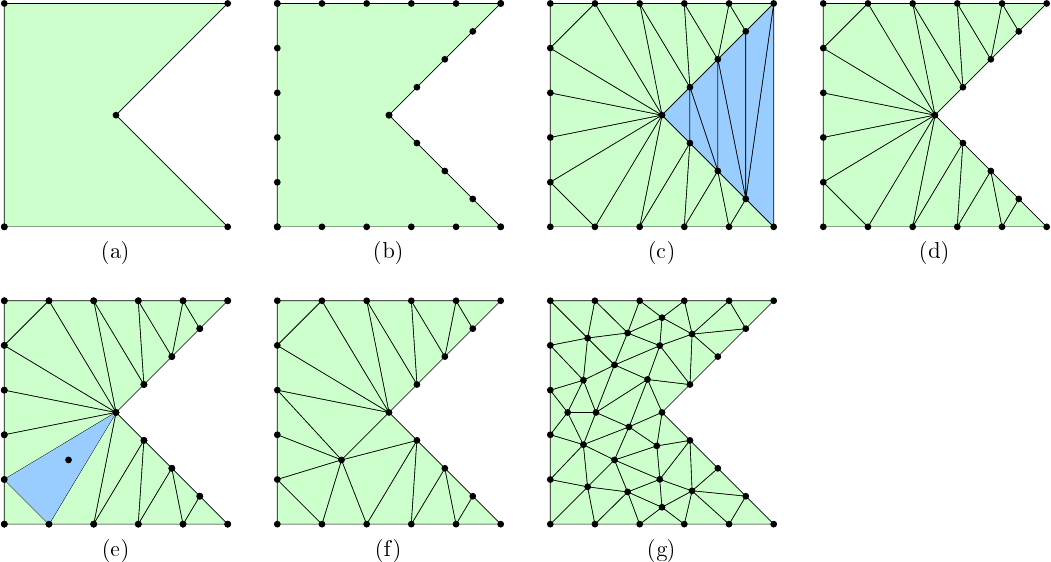

In [32]:
function pmesh(pv, hmax)
    p = []
    E = []
    for i = 1:(length(pv)-1)
         push!(E, [pv[i] pv[i+1]])
    end

    for j = 1:length(E)
        line_distance = sqrt((E[j][2,1]-E[j][2,2])^2 + (E[j][1,1]-E[j][1,2])^2)
        number_of_line_segments = ceil(line_distance/hmax)
        for i = 1:number_of_line_segments
        push!(p, E[j][:,1]+((E[j][:,2]-E[j][:,1])*(i/number_of_line_segments)))
        end
    end
    
    
    dp = delaunay(p) #list of index triplets referring to elements in p
    up = []          #updated p
    for i = 1:length(dp)
        tri = p[dp[i]]
        if inpolygon(tri_centroid(tri),pv) == true
            push!(up, dp[i])
        end
    end
    
        A = []
        for i = 1:length(up)
            tri = p[up[i]]
            areas = tri_area(tri)
            push!(A, areas)
        end


        max_A = findmax(A)[1]
        max_A_index = findmax(A)[2]
        push!(p, tri_circumcenter(p[up[max_A_index]]))
    
    while max_A > ((hmax^2)/2)

        dp = delaunay(p) #list of index triplets referring to elements in p
        up = []          #updated p
        for i = 1:length(dp)
            tri = p[dp[i]]
            if inpolygon(tri_centroid(tri),pv) == true
                push!(up, dp[i])
            end
        end

        A = []
        for i = 1:length(up)
            tri = p[up[i]]
            areas = tri_area(tri)
            push!(A, areas)
        end


        max_A = findmax(A)[1]
        max_A_index = findmax(A)[2]
        push!(p, tri_circumcenter(p[up[max_A_index]]))
    end
    p,up
end

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

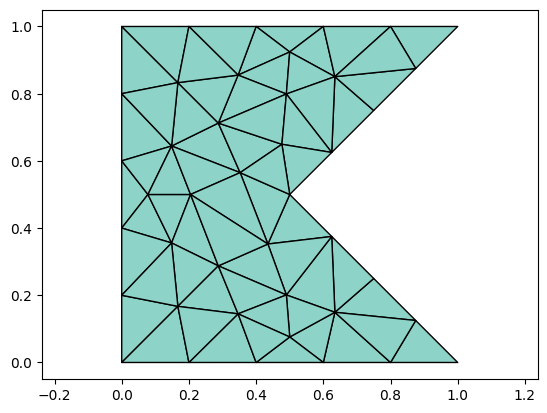

In [33]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

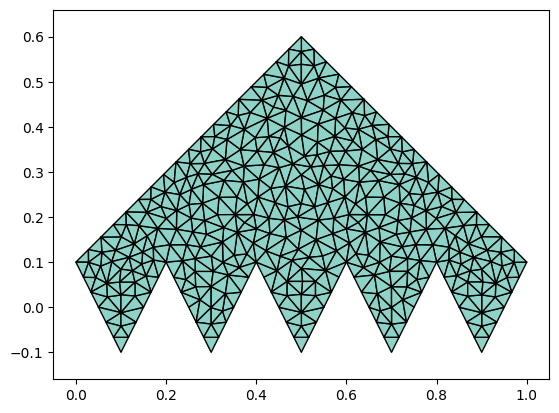

In [34]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)